In [8]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from feature_engine.imputation import MeanMedianImputer, CategoricalImputer, AddMissingIndicator
from feature_engine.wrappers import SklearnTransformerWrapper

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Binarizer

pd.set_option('display.max_columns', False)

In [9]:
df = pd.read_csv('../datasets/train.csv')
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,NaN,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,NaN,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [10]:
target = df['SalePrice']
df.drop(['Id', 'SalePrice'], axis=1, inplace=True)

num_features = [var for var in df.columns if df[var].dtype != 'object' and var != 'MSSubClass']
cat_features = [var for var in df.columns if var not in num_features]
# cast all categorical + MSSubCLass to object type - non numeric
df[cat_features] = df[cat_features].astype('object')
print(num_features)
print(cat_features)

['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold']
['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCon

## Split dataset and transform target variable

In [11]:


X_train, X_test, y_train, y_test = train_test_split(df, target, test_size=0.1, random_state=1)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

y_train = np.log(y_train)
y_test = np.log(y_test)

# Feature engineering

* missing values
* temporal variables
* non gaussian distribution
* categorical variables - removing rare values
* encoding
* standardization (scaling)

## Imputation of missing values

* categorical values
* numerical values

## Categorical features


In [12]:
# first make a list of categorical vars with missing data
cat_with_na = [var for var in cat_features if X_train[var].isnull().sum() > 0]

X_train[cat_with_na].isnull().mean().sort_values(ascending=False)

PoolQC          0.995434
MiscFeature     0.962709
Alley           0.936073
Fence           0.808980
MasVnrType      0.592085
FireplaceQu     0.475647
GarageType      0.055556
GarageFinish    0.055556
GarageQual      0.055556
GarageCond      0.055556
BsmtExposure    0.026636
BsmtFinType2    0.026636
BsmtQual        0.025875
BsmtCond        0.025875
BsmtFinType1    0.025875
Electrical      0.000761
dtype: float64

In [13]:
with_string_missing = [var for var in cat_with_na if X_train[var].isnull().mean() >= 0.1]
with_most_frequent = [var for var in cat_with_na if X_train[var].isnull().mean() < 0.1]

print(with_string_missing)
print(with_most_frequent)

['Alley', 'MasVnrType', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature']
['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Electrical', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']


In [14]:
cat_imputer_missing = CategoricalImputer(imputation_method='missing', variables=with_string_missing)

cat_imputer_missing.fit(X_train)

X_train = cat_imputer_missing.transform(X_train)
X_test = cat_imputer_missing.transform(X_test)

X_train[with_string_missing].isnull().sum()

Alley          0
MasVnrType     0
FireplaceQu    0
PoolQC         0
Fence          0
MiscFeature    0
dtype: int64

In [15]:
cat_imputer_frequent = CategoricalImputer(imputation_method='frequent', variables=with_most_frequent)

cat_imputer_frequent.fit(X_train)

X_train = cat_imputer_frequent.transform(X_train)
X_test = cat_imputer_frequent.transform(X_test)

print(cat_imputer_frequent.imputer_dict_)

X_train[with_most_frequent].isnull().sum()

{'BsmtQual': 'TA', 'BsmtCond': 'TA', 'BsmtExposure': 'No', 'BsmtFinType1': 'Unf', 'BsmtFinType2': 'Unf', 'Electrical': 'SBrkr', 'GarageType': 'Attchd', 'GarageFinish': 'Unf', 'GarageQual': 'TA', 'GarageCond': 'TA'}


BsmtQual        0
BsmtCond        0
BsmtExposure    0
BsmtFinType1    0
BsmtFinType2    0
Electrical      0
GarageType      0
GarageFinish    0
GarageQual      0
GarageCond      0
dtype: int64

In [16]:
# check if all categorical columns are imputed now (expect [])
X_train[cat_features].columns[X_train[cat_features].isnull().sum() > 0].to_list()

[]

In [17]:
# check if all categorical columns are imputed now (expect [])
X_test[cat_features].columns[X_test[cat_features].isnull().sum() > 0].to_list()

[]

## Numerical features

Now it's time to transform numerical variables.

In [18]:
# Let's work on numerical variables
num_vars_with_na = [var for var in X_train[num_features] if X_train[var].isnull().sum() > 0]
num_vars_with_na

['LotFrontage', 'MasVnrArea', 'GarageYrBlt']

In [19]:
missing_ind_imp = AddMissingIndicator(variables=num_vars_with_na)

missing_ind_imp.fit(X_train)

X_train = missing_ind_imp.transform(X_train)
X_test = missing_ind_imp.transform(X_test)


In [20]:
mean_imputer = MeanMedianImputer(imputation_method='mean', variables=num_vars_with_na)

mean_imputer.fit(X_train)

X_train = mean_imputer.transform(X_train)
X_test = mean_imputer.transform(X_test)

In [21]:
mean_imputer.imputer_dict_

{'LotFrontage': 70.09343200740055,
 'MasVnrArea': 103.94640122511485,
 'GarageYrBlt': 1978.7219983883965}

In [22]:
X_train[num_vars_with_na].isnull().sum()

LotFrontage    0
MasVnrArea     0
GarageYrBlt    0
dtype: int64

### Temporal variables

#### Capture elapsed time

We learned in the previous notebook, that there are 4 variables that refer to the years in which the house or the garage were built or remodeled. 

We will capture the time elapsed between those variables and the year in which the house was sold:

In [23]:
def elapsed_years(df, var):
    df[var] = df['YrSold'] - df[var]
    return df

yr_vars = ['YearBuilt', 'YearRemodAdd', 'GarageYrBlt']
for var in yr_vars:
    X_train = elapsed_years(X_train, var)
    X_test = elapsed_years(X_test, var)

In [24]:
X_train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,...,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,LotFrontage_na,MasVnrArea_na,GarageYrBlt_na
418,50,RL,60.0,8160,Pave,Missing,Reg,Lvl,AllPub,Inside,Gtl,Edwards,Norm,Norm,1Fam,1.5Fin,5,6,67,57,Gable,CompShg,MetalSd,MetalSd,Missing,0.0,TA,TA,BrkTil,TA,TA,No,ALQ,312,Unf,0,444,756,GasA,Fa,...,756,378,0,1134,1,0,1,1,3,1,TA,7,Typ,0,Missing,Detchd,67.0,Unf,1,240,TA,TA,P,0,0,0,0,0,0,Missing,Missing,Missing,0,4,2007,WD,AdjLand,0,0,0
782,20,RL,67.0,16285,Pave,Missing,IR2,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,1Story,7,5,8,7,Gable,CompShg,VinylSd,VinylSd,Missing,0.0,Gd,TA,PConc,Gd,TA,No,Unf,0,Unf,0,1413,1413,GasA,Ex,...,1430,0,0,1430,0,0,2,0,3,1,Gd,6,Typ,0,Missing,Attchd,8.0,RFn,2,605,TA,TA,Y,0,33,0,0,0,0,Missing,Missing,Missing,0,6,2009,WD,Normal,0,0,0
1338,60,RL,95.0,13450,Pave,Missing,IR1,Lvl,AllPub,Corner,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,4,4,Gable,CompShg,VinylSd,VinylSd,Missing,0.0,Gd,TA,PConc,Gd,TA,No,GLQ,700,Unf,0,216,916,GasA,Ex,...,920,941,0,1861,1,0,2,1,3,1,Gd,8,Typ,0,Missing,BuiltIn,4.0,RFn,2,492,TA,TA,Y,146,91,0,0,0,0,Missing,Missing,Missing,0,6,2006,WD,Normal,0,0,0
931,20,RL,70.0,9100,Pave,Missing,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,5,6,44,44,Gable,CompShg,VinylSd,VinylSd,Missing,0.0,TA,TA,CBlock,TA,TA,No,BLQ,338,Rec,466,121,925,GasA,Ex,...,925,0,0,925,0,1,1,0,2,1,TA,5,Typ,0,Missing,Detchd,44.0,Unf,1,429,TA,TA,Y,0,0,0,0,0,0,Missing,GdWo,Missing,0,7,2009,WD,Normal,0,0,0
780,20,RL,63.0,7875,Pave,Missing,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,1Story,7,5,12,11,Gable,CompShg,HdBoard,HdBoard,BrkFace,38.0,TA,TA,PConc,Gd,Gd,No,Unf,0,Unf,0,1237,1237,GasA,Gd,...,1253,0,0,1253,0,0,2,0,3,1,TA,6,Typ,1,TA,Attchd,12.0,Fin,2,402,TA,TA,Y,220,21,0,0,0,0,Missing,Missing,Missing,0,6,2007,WD,Normal,0,0,0


### Log transformation

This comes in handy for variables which do not have Gaussian like distribution.
Log transformation may help us get there. Let's check.

In [25]:
for var in ["LotFrontage", "1stFlrSF", "GrLivArea"]:
    X_train[var] = np.log(X_train[var])
    X_test[var] = np.log(X_test[var])

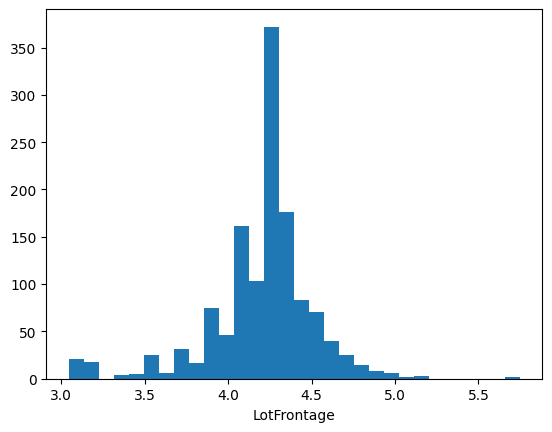

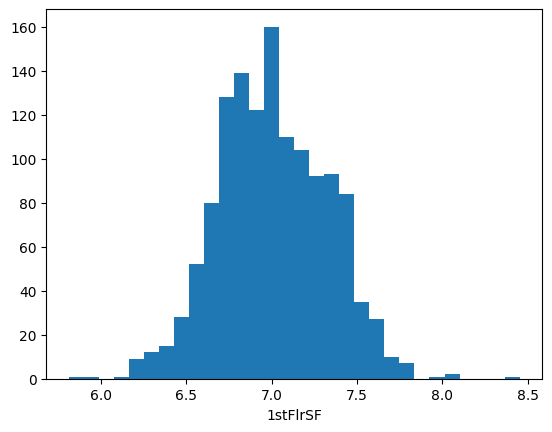

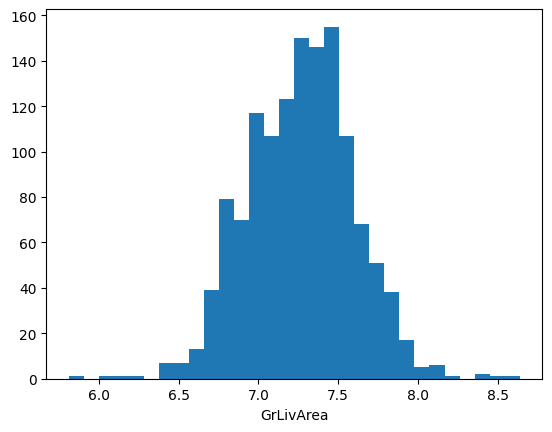

In [26]:
for var in ["LotFrontage", "1stFlrSF", "GrLivArea"]:
    plt.hist(X_train[var], bins=30)
    plt.xlabel(var)
    plt.show()

### Binarizing skewed variables

For skewed variables we will binarize them and assing 0 or 1 based on existing values.

In [27]:
skewed = [
    'BsmtFinSF2', 'LowQualFinSF', 'EnclosedPorch',
    '3SsnPorch', 'ScreenPorch', 'MiscVal'
]

# wrapper for sklearn presrocessing transformers that allows to use them on selected number of variables
binarizer = SklearnTransformerWrapper(
    transformer=Binarizer(threshold=0), variables=skewed
)

binarizer.fit(X_train)

X_train = binarizer.transform(X_train)
X_test = binarizer.transform(X_test)

X_train[skewed]

,BsmtFinSF2,LowQualFinSF,EnclosedPorch,3SsnPorch,ScreenPorch,MiscVal
418,0,0,0,0,0,0
782,0,0,0,0,0,0
1338,0,0,0,0,0,0
931,1,0,0,0,0,0
780,0,0,0,0,0,0
...,...,...,...,...,...,...
715,0,0,0,0,0,0
905,1,0,1,0,0,0
1096,0,0,1,0,0,0
235,0,0,0,0,0,0


### Yeo-Johnson transformation for selected variables

We will apply this to LotArea

In [28]:
from feature_engine.transformation import YeoJohnsonTransformer

yeo_transformer = YeoJohnsonTransformer(
    variables=['LotArea'])

X_train = yeo_transformer.fit_transform(X_train)
X_test = yeo_transformer.transform(X_test)

# the learned parameter
yeo_transformer.lambda_dict_

{'LotArea': 0.024508194554606795}

## Encoding of categorical variables

Now it's time to encode categorical variables to numerical before we finalize the pipeline.
Here are the steps:

* apply mappings
* removing rare labels
* encode categorical features


Applying mappings

In [29]:
import json

with open('../mappings/quality_vars.json', 'r') as f:
    quality_vars = json.load(f)

print(quality_vars)

with open('../mappings/quality_mappings.json', 'r') as f:
    quality_mappings = json.load(f)

print(quality_mappings)

{'quality': ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'HeatingQC', 'KitchenQual', 'FireplaceQu', 'GarageQual', 'GarageCond'], 'exposure': ['BsmtExposure'], 'finish': ['BsmtFinType1', 'BsmtFinType2'], 'garage': ['GarageFinish'], 'fence': ['Fence']}
{'quality': {'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5, 'Missing': 0, 'NA': 0}, 'exposure': {'No': 1, 'Mn': 2, 'Av': 3, 'Gd': 4}, 'finish': {'Missing': 0, 'NA': 0, 'Unf': 1, 'LwQ': 2, 'Rec': 3, 'BLQ': 4, 'ALQ': 5, 'GLQ': 6}, 'garage': {'Missing': 0, 'NA': 0, 'Unf': 1, 'RFn': 2, 'Fin': 3}, 'fence': {'Missing': 0, 'NA': 0, 'MnWw': 1, 'GdWo': 2, 'MnPrv': 3, 'GdPrv': 4}}


In [30]:
# apply mappings to the same type of variables
# i.e. apply same quality mapping to all 'wuality' variables

def apply_mappings(df, mappings, vars):
  for var in vars:
    df[var] = df[var].map(mappings)
  return df

# loop through all mappings and apply them to respective variables
# this should 'encode' all quality variables
# we may need to check for NaN values after transformation

for k in quality_mappings.keys():
  map = quality_mappings[k]
  vars = quality_vars[k]
  X_train = apply_mappings(X_train, map, vars)
  X_test = apply_mappings(X_test, map, vars)

In [31]:
X_train

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,...,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,LotFrontage_na,MasVnrArea_na,GarageYrBlt_na
418,50,RL,4.094345,10.078650,Pave,Missing,Reg,Lvl,AllPub,Inside,Gtl,Edwards,Norm,Norm,1Fam,1.5Fin,5,6,67,57,Gable,CompShg,MetalSd,MetalSd,Missing,0.0,3,3,BrkTil,3,3,1,5,312,1,0,444,756,GasA,2,...,6.628041,378,0,7.033506,1,0,1,1,3,1,3,7,Typ,0,0,Detchd,67.000000,1,1,240,3,3,P,0,0,0,0,0,0,Missing,0,Missing,0,4,2007,WD,AdjLand,0,0,0
782,20,RL,4.204693,10.947594,Pave,Missing,IR2,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,1Story,7,5,8,7,Gable,CompShg,VinylSd,VinylSd,Missing,0.0,4,3,PConc,4,3,1,1,0,1,0,1413,1413,GasA,5,...,7.265430,0,0,7.265430,0,0,2,0,3,1,4,6,Typ,0,0,Attchd,8.000000,2,2,605,3,3,Y,0,33,0,0,0,0,Missing,0,Missing,0,6,2009,WD,Normal,0,0,0
1338,60,RL,4.553877,10.705595,Pave,Missing,IR1,Lvl,AllPub,Corner,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,4,4,Gable,CompShg,VinylSd,VinylSd,Missing,0.0,4,3,PConc,4,3,1,6,700,1,0,216,916,GasA,5,...,6.824374,941,0,7.528869,1,0,2,1,3,1,4,8,Typ,0,0,BuiltIn,4.000000,2,2,492,3,3,Y,146,91,0,0,0,0,Missing,0,Missing,0,6,2006,WD,Normal,0,0,0
931,20,RL,4.248495,10.214778,Pave,Missing,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,5,6,44,44,Gable,CompShg,VinylSd,VinylSd,Missing,0.0,3,3,CBlock,3,3,1,4,338,3,1,121,925,GasA,5,...,6.829794,0,0,6.829794,0,1,1,0,2,1,3,5,Typ,0,0,Detchd,44.000000,1,1,429,3,3,Y,0,0,0,0,0,0,Missing,2,Missing,0,7,2009,WD,Normal,0,0,0
780,20,RL,4.143135,10.034342,Pave,Missing,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,1Story,7,5,12,11,Gable,CompShg,HdBoard,HdBoard,BrkFace,38.0,3,3,PConc,4,4,1,1,0,1,0,1237,1237,GasA,4,...,7.133296,0,0,7.133296,0,0,2,0,3,1,3,6,Typ,1,3,Attchd,12.000000,3,2,402,3,3,Y,220,21,0,0,0,0,Missing,0,Missing,0,6,2007,WD,Normal,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
715,20,RL,4.356709,10.350248,Pave,Missing,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,Norm,1Fam,1Story,6,5,35,35,Hip,CompShg,HdBoard,HdBoard,BrkFace,174.0,3,3,CBlock,4,3,1,1,0,1,0,1064,1064,GasA,3,...,7.207860,0,0,7.207860,0,0,2,0,3,1,3,7,Typ,1,3,Attchd,35.000000,2,2,478,3,3,Y,0,0,0,0,0,0,Missing,3,Missing,0,8,2009,WD,Normal,0,0,0
905,20,RL,4.382027,10.322759,Pave,Missing,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,5,5,56,56,Gable,CompShg,HdBoard,HdBoard,Stone,110.0,3,3,CBlock,3,3,1,3,354,2,1,412,1056,GasA,3,...,6.968850,0,0,6.968850,1,0,1,0,3,1,3,6,Typ,0,0,Attchd,56.000000,2,1,280,3,3,Y,0,0,1,0,0,0,Missing,3,Missing,0,2,2010,WD,Normal,0,0,0
1096,70,RM,4.094345,9.866712,Pave,Missing,Reg,Lvl,AllPub,Inside,Gtl,IDOTRR,Norm,Norm,1Fam,2Story,6,7,93,1,Gable,CompShg,Wd Sdng,Wd Sdng,Missing,0.0,3,3,PConc,3,3,1,1,0,1,0,684,684,GasA,3,...,6.650279,582,0,7.211557,0,0,1,1,3,1,4,7,Typ,0,0,Attchd,28.278002,1,0,0,3,3,Y,136,0,1,0,0,0,Missing,0,Missing,0,3,2007,WD,Normal,0,0,1
235,160,RM,3.044522,8.146061,Pave,Missing,Reg,Lvl,AllPub,Inside,Gtl,BrDale,Norm,Norm,TwnhsE,2Story,6,3,37,37,Gable,CompShg,HdBoard,HdBoard,BrkFace,604.0,3,3,CBlock,3,3,1,5,358,1,0,

In [32]:
# check absence of na in the train set
[var for var in X_train.columns if X_train[var].isnull().sum() > 0]

[]

Removing rare labels

In [35]:
from feature_engine.encoding import RareLabelEncoder

# capture all quality variables

qual_vars  = quality_vars['quality'] + quality_vars['finish'] + ['BsmtExposure','GarageFinish','Fence']

# capture the remaining categorical variables
# (those that we did not re-map)

cat_others = [
    var for var in cat_features if var not in qual_vars
]

len(cat_others)


30

In [36]:
rare_encoder = RareLabelEncoder(tol=0.01, n_categories=1, variables=cat_others)

# find common labels
rare_encoder.fit(X_train)

# the common labels are stored, we can save the class
# and then use it later :)
rare_encoder.encoder_dict_

{'MSSubClass': [20, 60, 50, 120, 30, 160, 70, 80, 90, 190, 85],
 'MSZoning': ['RL', 'RM', 'FV'],
 'Street': ['Pave'],
 'Alley': ['Missing', 'Grvl', 'Pave'],
 'LotShape': ['Reg', 'IR1', 'IR2'],
 'LandContour': ['Lvl', 'Bnk', 'HLS', 'Low'],
 'Utilities': ['AllPub'],
 'LotConfig': ['Inside', 'Corner', 'CulDSac', 'FR2'],
 'LandSlope': ['Gtl', 'Mod'],
 'Neighborhood': ['NAmes',
  'CollgCr',
  'OldTown',
  'Edwards',
  'Somerst',
  'Gilbert',
  'NWAmes',
  'NridgHt',
  'Sawyer',
  'BrkSide',
  'SawyerW',
  'Crawfor',
  'Mitchel',
  'NoRidge',
  'Timber',
  'IDOTRR',
  'ClearCr',
  'StoneBr',
  'SWISU',
  'MeadowV',
  'BrDale'],
 'Condition1': ['Norm', 'Feedr', 'Artery', 'RRAn', 'PosN'],
 'Condition2': ['Norm'],
 'BldgType': ['1Fam', 'TwnhsE', 'Duplex', 'Twnhs', '2fmCon'],
 'HouseStyle': ['1Story', '2Story', '1.5Fin', 'SLvl', 'SFoyer'],
 'RoofStyle': ['Gable', 'Hip'],
 'RoofMatl': ['CompShg'],
 'Exterior1st': ['VinylSd',
  'MetalSd',
  'HdBoard',
  'Wd Sdng',
  'Plywood',
  'CemntBd',
  'BrkF

In [37]:
X_train = rare_encoder.transform(X_train)
X_test = rare_encoder.transform(X_test)

Encoding of categorical features

We will use ordinal encoding in our case.

In [38]:
from feature_engine.encoding import OrdinalEncoder

# set up the encoder
cat_encoder = OrdinalEncoder(encoding_method='ordered', variables=cat_others)

# create the mappings
cat_encoder.fit(X_train, y_train)

# mappings are stored and class can be saved
cat_encoder.encoder_dict_

{'MSSubClass': {30: 0,
  'Rare': 1,
  190: 2,
  90: 3,
  160: 4,
  50: 5,
  85: 6,
  70: 7,
  80: 8,
  20: 9,
  120: 10,
  60: 11},
 'MSZoning': {'Rare': 0, 'RM': 1, 'RL': 2, 'FV': 3},
 'Street': {'Rare': 0, 'Pave': 1},
 'Alley': {'Grvl': 0, 'Pave': 1, 'Missing': 2},
 'LotShape': {'Reg': 0, 'IR1': 1, 'IR2': 2, 'Rare': 3},
 'LandContour': {'Bnk': 0, 'Lvl': 1, 'Low': 2, 'HLS': 3},
 'Utilities': {'Rare': 0, 'AllPub': 1},
 'LotConfig': {'Inside': 0, 'Corner': 1, 'FR2': 2, 'CulDSac': 3, 'Rare': 4},
 'LandSlope': {'Gtl': 0, 'Mod': 1, 'Rare': 2},
 'Neighborhood': {'IDOTRR': 0,
  'MeadowV': 1,
  'BrDale': 2,
  'BrkSide': 3,
  'OldTown': 4,
  'Edwards': 5,
  'Sawyer': 6,
  'SWISU': 7,
  'NAmes': 8,
  'Mitchel': 9,
  'Rare': 10,
  'SawyerW': 11,
  'NWAmes': 12,
  'Gilbert': 13,
  'CollgCr': 14,
  'Crawfor': 15,
  'ClearCr': 16,
  'Somerst': 17,
  'Timber': 18,
  'NridgHt': 19,
  'StoneBr': 20,
  'NoRidge': 21},
 'Condition1': {'Artery': 0,
  'Feedr': 1,
  'Norm': 2,
  'RRAn': 3,
  'Rare': 4,
  '

In [39]:
X_train = cat_encoder.transform(X_train)
X_test = cat_encoder.transform(X_test)

In [40]:
# check absence of na in the train set
[var for var in X_train.columns if X_train[var].isnull().sum() > 0]

[]

In [41]:
# check absence of na in the train set
[var for var in X_test.columns if X_test[var].isnull().sum() > 0]

[]

## Feature scaling

In [44]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

scaler.fit(X_train)
# transform the train and test set

# sklearn returns numpy arrays, so we wrap the
# array with a pandas dataframe

X_train = pd.DataFrame(
    scaler.transform(X_train),
    columns=X_train.columns
)

X_test = pd.DataFrame(
    scaler.transform(X_test),
    columns=X_train.columns
)

In [45]:
X_train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,...,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,LotFrontage_na,MasVnrArea_na,GarageYrBlt_na
0,0.454545,0.666667,0.388581,0.345112,1.0,1.0,0.000000,0.333333,1.0,0.00,0.0,0.238095,0.4,1.0,1.0,0.2,0.444444,0.571429,0.492647,0.950820,0.0,0.0,0.3,0.4,0.333333,0.00000,0.333333,0.5,0.25,0.333333,0.666667,0.0,0.8,0.055280,0.0,0.0,0.190068,0.123732,1.0,0.000000,...,0.309142,0.183051,0.0,0.432412,0.333333,0.0,0.333333,0.5,0.375,0.5,0.333333,0.416667,1.0,0.000000,0.0,0.25,0.626168,0.0,0.25,0.169252,0.5,0.5,0.5,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.272727,0.25,0.666667,0.25,0.0,0.0,0.0
1,0.818182,0.666667,0.429425,0.479045,1.0,1.0,0.666667,0.333333,1.0,0.00,0.0,0.666667,0.4,1.0,1.0,0.6,0.666667,0.428571,0.058824,0.131148,0.0,0.0,0.9,1.0,0.333333,0.00000,0.666667,0.5,1.00,0.666667,0.666667,0.0,0.0,0.000000,0.0,0.0,0.604880,0.231260,1.0,1.000000,...,0.550351,0.000000,0.0,0.514455,0.000000,0.0,0.666667,0.0,0.375,0.5,0.666667,0.333333,1.0,0.000000,0.0,0.75,0.074766,0.5,0.50,0.426657,0.5,0.5,1.0,0.000000,0.060329,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.454545,0.75,0.666667,0.75,0.0,0.0,0.0
2,1.000000,0.666667,0.558672,0.441745,1.0,1.0,0.333333,0.333333,1.0,0.25,0.0,0.666667,0.4,1.0,1.0,1.0,0.666667,0.428571,0.029412,0.081967,0.0,0.0,0.9,1.0,0.333333,0.00000,0.666667,0.5,1.00,0.666667,0.666667,0.0,1.0,0.124026,0.0,0.0,0.092466,0.149918,1.0,1.000000,...,0.383441,0.455690,0.0,0.607647,0.333333,0.0,0.666667,0.5,0.375,0.5,0.666667,0.500000,1.0,0.000000,0.0,1.00,0.037383,0.5,0.50,0.346968,0.5,0.5,1.0,0.198370,0.166362,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.454545,0.00,0.666667,0.75,0.0,0.0,0.0
3,0.818182,0.666667,0.445638,0.366093,1.0,1.0,0.000000,0.333333,1.0,0.00,0.0,0.380952,0.4,1.0,1.0,0.6,0.444444,0.571429,0.323529,0.737705,0.0,0.0,0.9,1.0,0.333333,0.00000,0.333333,0.5,0.50,0.333333,0.666667,0.0,0.6,0.059887,0.4,1.0,0.051798,0.151391,1.0,1.000000,...,0.385492,0.000000,0.0,0.360349,0.000000,0.5,0.333333,0.0,0.250,0.5,0.333333,0.250000,1.0,0.000000,0.0,0.25,0.411215,0.0,0.25,0.302539,0.5,0.5,1.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.5,1.0,0.0,0.545455,0.75,0.666667,0.75,0.0,0.0,0.0
4,0.818182,0.666667,0.406640,0.338282,1.0,1.0,0.000000,0.333333,1.0,0.00,0.0,0.619048,0.4,1.0,1.0,0.6,0.666667,0.428571,0.088235,0.196721,0.0,0.0,0.6,0.5,0.666667,0.02375,0.333333,0.5,1.00,0.666667,1.000000,0.0,0.0,0.000000,0.0,0.0,0.529538,0.202455,1.0,0.666667,...,0.500348,0.000000,0.0,0.467713,0.000000,0.0,0.666667,0.0,0.375,0.5,0.333333,0.333333,1.0,0.333333,0.6,0.75,0.112150,1.0,0.50,0.283498,0.5,0.5,1.0,0.298913,0.038391,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.454545,0.25,0.666667,0.75,0.0,0.0,0.0
